Author: Chris J. Dallmann \
Affiliation: University of Wuerzburg \
Last revision: 04-January-2026

In [1]:
# Import libraries
import pandas as pd
import numpy as np
from scipy.ndimage import uniform_filter1d
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# Set parameters and load data
data_dir = r'../data/'
sampling_rate = 50 # Hz
filter_size = 0.3 # s

color_ctrl = [0,0,0]
color_rrn = [0/255, 174/255, 239/255]

In [6]:
def compute_mean_time_series(df,parameter_name,animal_ids,filter_size):

    # Initialize variables
    df_sub = df[df.animal_id==animal_ids[0]]
    trials = df_sub.trial.unique().tolist()
    
    n_frames = len(df_sub[df_sub.trial==trials[0]])
    mean_parameters = np.zeros((n_frames, len(animal_ids)))
    
    # Loop over animals
    for animal_id_index, animal_id in enumerate(animal_ids):
        df_sub = df[df.animal_id==animal_id]
        trials = df_sub.trial.unique().tolist()

        # Initialize variables
        mean_parameter = np.zeros((n_frames, len(trials)))

        # Loop over trials
        for trial_index, trial in enumerate(trials):
            parameter = df_sub[parameter_name][df_sub.trial==trial].to_numpy()   
            
            # Smooth
            parameter = uniform_filter1d(parameter, size=int(filter_size))
            
            # Flip angular and lateral velocity for left neurons
            if (parameter_name in ['angular_velocity','lateral_velocity']) and (df_sub.hemisphere.unique().item()=='left'): 
                parameter = parameter*-1
    
            mean_parameter[:,trial_index] = parameter
           
        mean_parameters[:,animal_id_index] = np.nanmean(mean_parameter,axis=1) 

    return mean_parameters

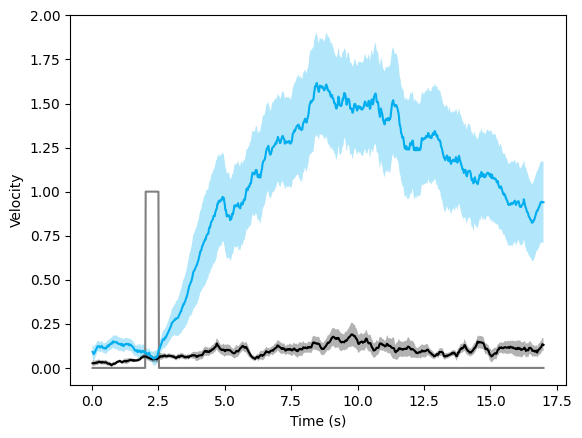

In [14]:
# Plot mean time series 

# Settings
parameter_name = "forward_velocity" 
start = 0 # s
end = 17 # s

# Compute mean time series per animal
dataset = 'treadmill_rrn_p2x2_control.csv'
df = pd.read_csv(data_dir+dataset) 
df = df[(df.time>start) & (df.time<=end)]
animal_ids = df.animal_id.unique().tolist()

mean_time_series_ctrl = compute_mean_time_series(df, parameter_name, animal_ids, filter_size*sampling_rate)

dataset = 'treadmill_rrn_p2x2.csv'
df = pd.read_csv(data_dir+dataset) 
df = df[(df.time>start) & (df.time<=end)]
animal_ids = df.animal_id.unique().tolist()
mean_time_series_rrn = compute_mean_time_series(df, parameter_name, animal_ids, filter_size*sampling_rate)

# Plot mean time course
time = df.time.unique().tolist()
stimulus = df.stimulus[(df.animal_id==animal_ids[0]) & (df.trial==1)].to_numpy()

mean_ctrl = np.mean(mean_time_series_ctrl,axis=1)
sem_ctrl = np.std(mean_time_series_ctrl,axis=1)/np.sqrt(np.size(mean_time_series_ctrl,1))

mean_rrn = np.mean(mean_time_series_rrn,axis=1)
sem_rrn = np.std(mean_time_series_rrn,axis=1)/np.sqrt(np.size(mean_time_series_rrn,1))

plt.plot(time, stimulus, color=[.5,.5,.5])
plt.plot(time, mean_ctrl, color=color_ctrl)
plt.fill_between(time, mean_ctrl-sem_ctrl, mean_ctrl+sem_ctrl, color=color_ctrl, alpha=0.3, edgecolor='none')
plt.plot(time, mean_rrn, color=color_rrn)
plt.fill_between(time, mean_rrn-sem_rrn, mean_rrn+sem_rrn, color=color_rrn, alpha=0.3, edgecolor='none')
plt.xlabel('Time (s)')
plt.ylabel('Velocity')
plt.show()

In [8]:
# Get sample size
dataset = 'treadmill_rrn_p2x2_control.csv'
df = pd.read_csv(data_dir+dataset) 
animal_ids = df.animal_id.unique().tolist()
print('N = ' + str(len(animal_ids)))

for animal_id in animal_ids:
    print('Animal ' + str(animal_id) + ': ' + str(len(df.trial[df["animal_id"]==animal_id].unique().tolist())))

N = 16
Animal 1: 27
Animal 2: 9
Animal 3: 11
Animal 4: 13
Animal 5: 16
Animal 6: 25
Animal 7: 18
Animal 8: 28
Animal 9: 26
Animal 10: 21
Animal 11: 15
Animal 12: 9
Animal 13: 26
Animal 14: 9
Animal 15: 13
Animal 16: 13


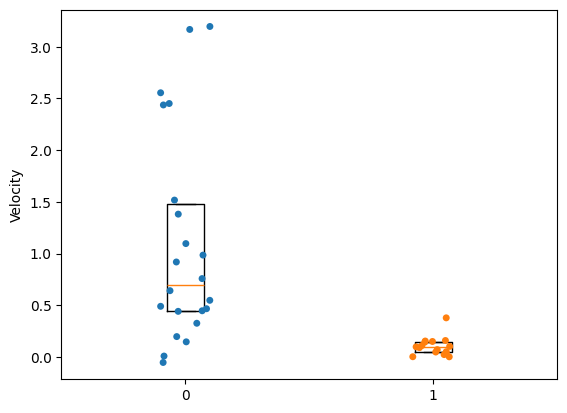

MannwhitneyuResult(statistic=np.float64(36.0), pvalue=np.float64(3.716960414362948e-05))

In [15]:
# Plot means of mean time series 

# Settings
parameter_name = "forward_velocity" 
start = 2 # s
end = 15 # s

# Compute means 
dataset = 'treadmill_rrn_p2x2_control.csv'
df = pd.read_csv(data_dir+dataset) 
df = df[(df.time>start) & (df.time<=end)]
animal_ids = df.animal_id.unique().tolist()
mean_time_series = compute_mean_time_series(df, parameter_name, animal_ids, filter_size*sampling_rate)
means_ctrl = np.mean(mean_time_series,axis=0)

dataset = 'treadmill_rrn_p2x2.csv'
df = pd.read_csv(data_dir+dataset) 
df = df[(df.time>start) & (df.time<=end)]
animal_ids = df.animal_id.unique().tolist()
mean_time_series = compute_mean_time_series(df, parameter_name, animal_ids, filter_size*sampling_rate)
means_rrn = np.mean(mean_time_series,axis=0)

# Plot means
plt.boxplot([means_rrn,means_ctrl], positions=[0,1], showfliers=False, whis=0)
sns.stripplot([means_rrn,means_ctrl])
plt.ylabel('Velocity')
plt.show()

# Mann-Whitney U test for non-normally distributed (nonparametric) data
stats.mannwhitneyu(means_ctrl,means_rrn)

In [12]:
# Read out number of trials per animal
n_trials = []
for animal_id in animal_ids:
    n_trials.append(len(df.trial[df.animal_id==animal_id].unique().tolist()))
n_trials

[54,
 41,
 20,
 22,
 13,
 9,
 34,
 17,
 16,
 41,
 8,
 14,
 26,
 31,
 8,
 19,
 7,
 14,
 14,
 9,
 13,
 20]